In [58]:
import numpy as np
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

  * Teraz przyjrzyjmy się, jak radzić sobie z szeregami czasowymi, takimi jak ceny akcji, temperatura powietrza, fael mózgowe (EEG) i tak dalej. 
  * Możmy nauczyć RNN przewidzieć następną wartość w szeregu czasowym.
  * Każda instancja uczące jest losowo wybraną sekwencją 20 kolejnych wartości z szeregów czasowych, a sekwencja docelowa jest taka sama jak sekwencja wejściowa, z tą różnicą, że jest przesunięta o jeden krok w przyszłość.

In [59]:
def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

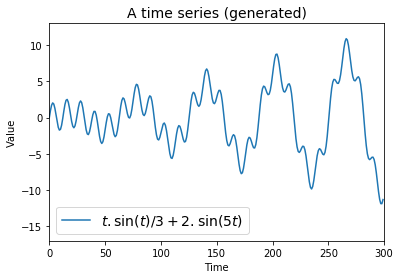

In [60]:
t_min, t_max = 0, 30
resolution = 0.1

t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))
ts = time_series(t)

plt.title("A time series (generated)", fontsize=14)
plt.plot(ts, label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 300, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

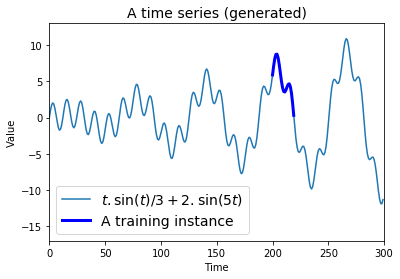

In [61]:
plt.title("A time series (generated)", fontsize=14)
plt.plot(ts, label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
start = 200
n_steps=20
ts_nan = np.zeros(ts.shape[0], dtype=float)
ts_nan.fill(np.nan)
ts_nan[start:(start+n_steps)] = ts[start:(start+n_steps)]

plt.plot(ts_nan, "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 300, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")


plt.show()

# Test tarin split

In [62]:
train, test = ts[0:-20], ts[-20:]
train_nan = np.zeros(train.shape[0], dtype=float)
train_nan.fill(np.nan)

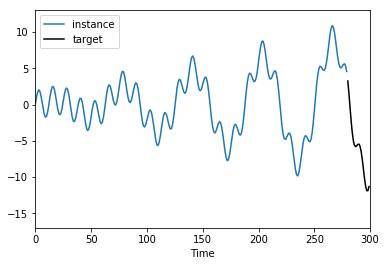

In [63]:
plt.plot( train, markersize=1, label="instance")
plt.plot(np.hstack((train_nan,test)), "k", markersize=10, label="target")
plt.legend(loc="upper left")
plt.axis([0, 300, -17, 13])
plt.xlabel("Time")
plt.show()

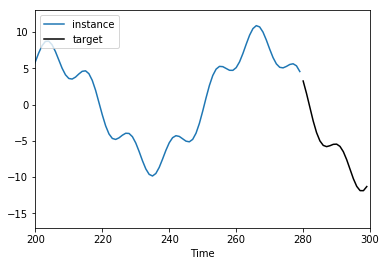

In [64]:
plt.plot( train, markersize=1, label="instance")
plt.plot(np.hstack((train_nan,test)), "k", markersize=10, label="target")
plt.legend(loc="upper left")
plt.axis([200, 300, -17, 13])
plt.xlabel("Time")
plt.show()

# Convert tumeseries to rnn input

In [65]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [66]:
def series_to_rnn(data,  n_steps):
    dataframe = series_to_supervised(data, n_steps-1)
    dataframe_2=series_to_supervised(dataframe,1).values # 1 - means we split into 2d array with shifft 1
#     return dataframe_2.reshape(2, -1, n_steps,1)
    X = dataframe_2[:,:n_steps]
    y= dataframe_2[:,n_steps:]
    return X.reshape(-1, n_steps, 1), y.reshape(-1, n_steps, 1)

In [67]:
import pandas as pd
df = pd.DataFrame()
df['t'] = [x for x in ts]

data_X, data_y = series_to_rnn(data=df, n_steps=20)
print(data_X.shape)
print(data_y.shape)

(280, 20, 1)
(280, 20, 1)


# Stwórzmy RNN

  * Będzie on zawierał 100 neuronów rekurencyjnych, 
  * Rozwiniemy go w ciągu 20 kolejnych etapów czsowych, ponieważ każda instancja ucząca będzie miała 20 wejść. 
  * Każde wejście zawiera tylko jedną wartość w tym czasie $t$. 
  * wynikiem rnn również będzie sekwencjami 20 wejść, z których każdy zawiera pojedynczą wartość. 

Kod jest prawie taki sam jak wcześniej.

  * Za każdym razem zwracamy wektor wyjściowy o wielkości 100. 
  * Ale to, czego naprawdę chcemy, to pojedyncza wartość wyjściowa w każdym kroku czasowym. 
  * Najprostszym rozwiązaniem jest obłorzenie warstwy funkcją **OutputProjectionWrapper**. 
  * Jest to normlana wastwa fully connected z liniwą funkcją katywacji (tj. bez żadnej funkcji aktywacji) na górze każdego wyjścia (nie wpływa na stan komórki). 
  * Wszystkie te warstwy fully connected współdzilą te same wagi i biasy (możliwe do nauczenia). 
  
Musimy zdefiniować funkcję kosztów. Będziemy używać błędu średniej kwadratowej (MSE), analogicznie jak w regresji.  

In [68]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [69]:
from sklearn.utils import shuffle

n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        X1, y1 = shuffle(data_X, data_y)
        X_batches = np.array_split(X1, (data_X.shape[0] // batch_size))    
        y_batches = np.array_split(y1, (data_X.shape[0] // batch_size)) 
        for batch_index in range(data_X.shape[0] // batch_size):
            print("\r{}%".format(100 * batch_index //  (data_X.shape[0] // batch_size) ), end="")

            X_batch = X_batches[batch_index]
            y_batch = y_batches[batch_index]
            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
        print(" ", epoch, " MSE:", mse) 
    save_path = saver.save(sess, "./my_time_series_model")

80%  0  MSE: 5.835104
80%  1  MSE: 3.756787
80%  2  MSE: 2.9862857
80%  3  MSE: 2.0841718
80%  4  MSE: 1.803057
80%  5  MSE: 1.4222597
80%  6  MSE: 1.1926297
80%  7  MSE: 1.1180208
80%  8  MSE: 1.0895678
80%  9  MSE: 0.8505238
80%  10  MSE: 0.8983064
80%  11  MSE: 0.9288655
80%  12  MSE: 0.79080516
80%  13  MSE: 0.69875
80%  14  MSE: 0.6722066
80%  15  MSE: 0.7125837
80%  16  MSE: 0.51591814
80%  17  MSE: 0.553067
80%  18  MSE: 0.48640105
80%  19  MSE: 0.44606477
80%  20  MSE: 0.44227806
80%  21  MSE: 0.39943108
80%  22  MSE: 0.45781216
80%  23  MSE: 0.35763696
80%  24  MSE: 0.35846236
80%  25  MSE: 0.337091
80%  26  MSE: 0.32895797
80%  27  MSE: 0.2783363
80%  28  MSE: 0.29948604
80%  29  MSE: 0.309669
80%  30  MSE: 0.31166855
80%  31  MSE: 0.30715528
80%  32  MSE: 0.27126616
80%  33  MSE: 0.23227234
80%  34  MSE: 0.20439322
80%  35  MSE: 0.309119
80%  36  MSE: 0.20134616
80%  37  MSE: 0.18922211
80%  38  MSE: 0.24945442
80%  39  MSE: 0.199675
80%  40  MSE: 0.18942451
80%  41  MSE: 0.

In [70]:
with tf.Session() as sess:                          
    saver.restore(sess, "./my_time_series_model")   

    df_temp = pd.DataFrame()
    df_temp['t'] = [x for x in train[-21:]]
    
    _, X_new = series_to_rnn(data=df_temp,  n_steps=20)
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [71]:
X_new

array([[[ 5.09788006],
        [ 5.89737618],
        [ 7.04132217],
        [ 8.34743243],
        [ 9.57501189],
        [10.48330821],
        [10.89006831],
        [10.71587796],
        [10.00336469],
        [ 8.90653689],
        [ 7.65288961],
        [ 6.48761666],
        [ 5.6136762 ],
        [ 5.14247676],
        [ 5.0673309 ],
        [ 5.26621093],
        [ 5.53311769],
        [ 5.63031995],
        [ 5.34857687],
        [ 4.56048662]]])

In [72]:
train[-20:]

array([ 5.09788006,  5.89737618,  7.04132217,  8.34743243,  9.57501189,
       10.48330821, 10.89006831, 10.71587796, 10.00336469,  8.90653689,
        7.65288961,  6.48761666,  5.6136762 ,  5.14247676,  5.0673309 ,
        5.26621093,  5.53311769,  5.63031995,  5.34857687,  4.56048662])

In [73]:
y_pred

array([[[ 5.150053 ],
        [ 6.264308 ],
        [ 7.6605763],
        [ 9.209175 ],
        [10.424163 ],
        [10.847429 ],
        [10.580026 ],
        [ 9.9650955],
        [ 8.829294 ],
        [ 7.6787047],
        [ 6.542964 ],
        [ 5.633748 ],
        [ 5.0962873],
        [ 5.030089 ],
        [ 5.2961826],
        [ 5.5528736],
        [ 5.632916 ],
        [ 5.3327327],
        [ 4.5309825],
        [ 3.2273326]]], dtype=float32)

In [74]:
y_pred.reshape(-1)

array([ 5.150053 ,  6.264308 ,  7.6605763,  9.209175 , 10.424163 ,
       10.847429 , 10.580026 ,  9.9650955,  8.829294 ,  7.6787047,
        6.542964 ,  5.633748 ,  5.0962873,  5.030089 ,  5.2961826,
        5.5528736,  5.632916 ,  5.3327327,  4.5309825,  3.2273326],
      dtype=float32)

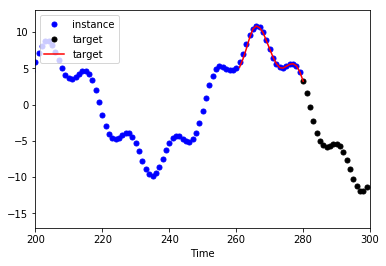

In [75]:
plt.plot( train, "b.", markersize=10 ,label="instance")
plt.plot(np.hstack((train_nan,test)), "k.", markersize=10, label="target")

plt.plot(np.hstack((train_nan[:-19],y_pred.reshape(-1))), "r", markersize=10, label="target")

plt.legend(loc="upper left")
plt.axis([200, 300, -17, 13])
plt.xlabel("Time")
plt.show()

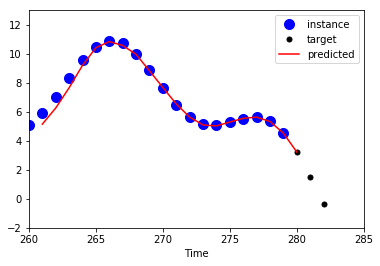

In [76]:
plt.plot( train, "b.", markersize=20 ,label="instance")
plt.plot(np.hstack((train_nan,test)), "k.", markersize=10, label="target")

plt.plot(np.hstack((train_nan[:-19],y_pred.reshape(-1))), "r", markersize=1, label="predicted")

plt.legend(loc="best")
plt.axis([260, 285, -2, 13])
plt.xlabel("Time")
plt.show()

# Without using an OutputProjectionWrapper

  * Chociaż użycie **OutputProjectionWrapper** jest najprostszym rozwiązaniem do zmniejszenia wymiarowości sekwencji wyjściowych RNN do zaledwie jednej wartości w ażdym kroku czasowy, nie jest to najbardziej wydajne. 

  * Istnieje bardziej skomplikowane, ale wydajniejsze rozwiązanie: 
    
    * możesz zmienić kształty wyjść RNN z [batch_size, n_steps, n_neurons] na [batch_size * n_steps, n_neurons], 
    * a następnie zastosować pojedynczą warstwę fully connected z odpowiednim rozmiarem wyjściowym (w naszym przypadku tylko 1) ), co spowoduje powstanie tensora wyjściowego kształtu [batch_size * n_steps, n_outputs], 
    * a następnie zmień kształt tego tensora na [batch_size, n_steps, n_outputs].

In [77]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)



In [185]:
n_outputs = 1
learning_rate = 0.001

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs]) # reshape

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [186]:
from sklearn.utils import shuffle

n_epochs = 1501
batch_size = 50

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        X1, y1 = shuffle(data_X, data_y)
        X_batches = np.array_split(X1, (data_X.shape[0] // batch_size))    
        y_batches = np.array_split(y1, (data_X.shape[0] // batch_size)) 
        for batch_index in range(data_X.shape[0] // batch_size):
            print("\r{}%".format(100 * batch_index //  (data_X.shape[0] // batch_size) ), end="")

            X_batch = X_batches[batch_index]
            y_batch = y_batches[batch_index]
            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
        if epoch % 100 ==0:
            print(" ", epoch, " MSE:", mse) 
    save_path = saver.save(sess, "./my_time_series_model_1")

80%  0  MSE: 8.375705
80%  100  MSE: 0.058574423
80%  200  MSE: 0.042736243
80%  300  MSE: 0.04921867
80%  400  MSE: 0.043987624
80%  500  MSE: 0.037215278
80%  600  MSE: 0.037407234
80%  700  MSE: 0.038143918
80%  800  MSE: 0.035328534
80%  900  MSE: 0.040157538
80%  1000  MSE: 0.042476676
80%  1100  MSE: 0.038602564
80%  1200  MSE: 0.03778021
80%  1300  MSE: 0.041438904
80%  1400  MSE: 0.034507062
80%  1500  MSE: 0.030236632


In [187]:
with tf.Session() as sess:                          
    saver.restore(sess, "./my_time_series_model_1")   

    df_temp = pd.DataFrame()
    df_temp['t'] = [x for x in train[-21:]]
    
    _, X_new = series_to_rnn(data=df_temp,  n_steps=20)
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model_1


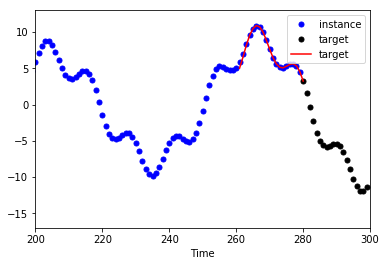

In [188]:
plt.plot( train, "b.", markersize=10 ,label="instance")
plt.plot(np.hstack((train_nan,test)), "k.", markersize=10, label="target")

plt.plot(np.hstack((train_nan[:-19],y_pred.reshape(-1))), "r", markersize=10, label="target")

plt.legend(loc="best")
plt.axis([200, 300, -17, 13])
plt.xlabel("Time")
plt.show()

# Prediction

In [189]:
with tf.Session() as sess:                          
    saver.restore(sess, "./my_time_series_model_1")   

    sequence = list(train[-20:])
    for iteration in range(20):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model_1


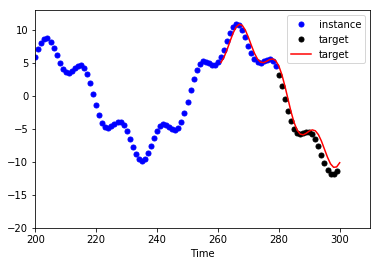

In [190]:
plt.plot( train, "b.", markersize=10 ,label="instance")
plt.plot(np.hstack((train_nan,test)), "k.", markersize=10, label="target")

plt.plot(np.hstack((train_nan[:-19], sequence)), "r", markersize=10, label="target")

plt.legend(loc="best")
plt.axis([200, 310, -20, 13])
plt.xlabel("Time")
plt.show()


# Prediction with update

In [191]:
with tf.Session() as sess:                          
    saver.restore(sess, "./my_time_series_model_1")   

    sequence = list(train[-20:])
    sequence_u = list(train[-20:])
    for iteration in range(20):
        X_batch = np.array(sequence_u[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])
        sequence_u.append( test[iteration] )

INFO:tensorflow:Restoring parameters from ./my_time_series_model_1


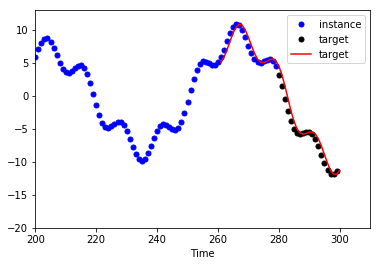

In [192]:
plt.plot( train, "b.", markersize=10 ,label="instance")
plt.plot(np.hstack((train_nan,test)), "k.", markersize=10, label="target")

plt.plot(np.hstack((train_nan[:-19], sequence)), "r", markersize=10, label="target")

plt.legend(loc="best")
plt.axis([200, 310, -20, 13])
plt.xlabel("Time")
plt.show()


# Creative RNN

  * Teraz, gdy mamy model, który może przewidzieć przyszłość, możemy go wykorzystać do wygenerowania nowych sekwencji
  * Wszystko, czego potrzebujemy, to 
    * dostarczyć sekwencję początkową zawierającą wartości n_steps (np. Pełne zera), 
    * użyć modelu do przewidywania następnej wartości, 
    * dołączyć tę przewidywaną wartość do sekwencji, 
    * podać ostatnie wartości n_steps do modelu, aby przewidzieć następny wartość i tak dalej. 
  * Ten proces generuje nową sekwencję, która ma pewne podobieństwo do oryginalnego szeregu czasowego

In [193]:
with tf.Session() as sess:                        
    saver.restore(sess, "./my_time_series_model_1") 

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model_1


In [194]:
X_batch.shape

(1, 20, 1)

In [195]:
sequence

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0024612304,
 -0.008723533,
 -0.021636521,
 -0.042652287,
 -0.07279066,
 -0.11165861,
 -0.15776482,
 -0.20868495,
 -0.26161757,
 -0.31397417,
 -0.36390927,
 -0.41072038,
 -0.4549276,
 -0.4980705,
 -0.54224163,
 -0.5894789,
 -0.6411503,
 -0.6975042,
 -0.7574839,
 -0.81884986,
 -0.8786171,
 -0.9336652,
 -0.9814053,
 -1.0203238,
 -1.0502646,
 -1.0724014,
 -1.0888838,
 -1.1021831,
 -1.1143827,
 -1.1265715,
 -1.1384599,
 -1.1483587,
 -1.1535269,
 -1.1507753,
 -1.1372415,
 -1.1110973,
 -1.072024,
 -1.0213647,
 -0.9618929,
 -0.8972843,
 -0.8313158,
 -0.7671378,
 -0.7065384,
 -0.6497063,
 -0.59526056,
 -0.5407154,
 -0.48327985,
 -0.4206802,
 -0.3518614,
 -0.2773935,
 -0.19947806,
 -0.121540464,
 -0.047538675,
 0.018879736,
 0.07515546,
 0.12033387,
 0.15521786,
 0.18208596,
 0.2040281,
 0.2241163,
 0.24454424,
 0.2660267,
 0.28753313,
 0.3064681,
 0.31923613,
 0.32208332,


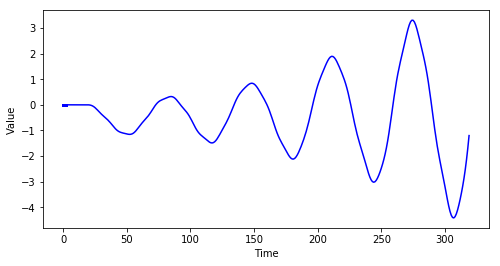

In [196]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# ...

In [197]:
with tf.Session() as sess:                          
    saver.restore(sess, "./my_time_series_model_1")   

    sequence = list(train[-20:])
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model_1


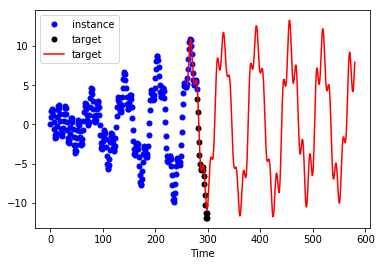

In [198]:
plt.plot( train, "b.", markersize=10 ,label="instance")
plt.plot(np.hstack((train_nan,test)), "k.", markersize=10, label="target")

plt.plot(np.hstack((train_nan[:-19], sequence)), "r", markersize=10, label="target")

plt.legend(loc="best")
#plt.axis([200, 600, -30, 30])
plt.xlabel("Time")
plt.show()

In [201]:
t = np.linspace(t_min, 2*t_max, 2*int((t_max - t_min) / resolution))
ts1 = time_series(t)

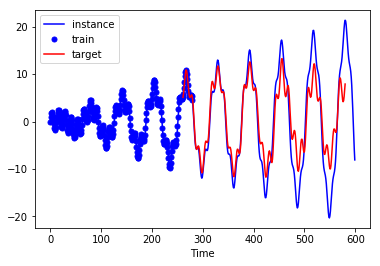

In [200]:
plt.plot(ts1, "b-", markersize=10 ,label="instance")
plt.plot( train, "b.", markersize=10 ,label="train")

plt.plot(np.hstack((train_nan[:-19], sequence)), "r", markersize=10, label="target")

plt.legend(loc="best")
#plt.axis([200, 600, -30, 30])
plt.xlabel("Time")
plt.show()